# Mapping sorted B cells on reference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.sparse
import anndata
import scrublet as scr

ModuleNotFoundError: No module named 'squidpy'

In [ ]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/sortedBcells/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    

### Load scRNA-seq data

In [35]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/sorted_B_cells/'

In [36]:
sample_ls = [x for x in os.listdir(data_dir) if x.startswith('WSS')]

min_n_count = 2000; min_n_gene = 500; max_n_gene = 7000
adata_ls = []
for s in sample_ls:
    adata = sc.read_10x_h5(data_dir + s + '/filtered_feature_bc_matrix.h5')
    adata.obs_names = [s + "-" + x.strip("-1") for x in adata.obs_names]
    # calculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)

    # filter cells
    print("Filtering cells...")
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > min_n_count))
    clist.append(np.array(adata.obs['n_genes'] > min_n_gene))
    clist.append(np.array(adata.obs['n_genes'] < max_n_gene))

    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()

    adata = adata[:,np.argsort(adata.var.gene_ids)]
    adata.obs['file'] = s

    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    adata_ls.append(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


Filtering cells...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtering cells...


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtering cells...


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


Filtering cells...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [37]:
for a in adata_ls:
    a.var['gene_name'] = a.var_names.copy()
    a.var_names = a.var['gene_ids'].copy()

In [38]:
sortedB_adata = anndata.concat(adata_ls)

In [39]:
## prep for scArches
sortedB_adata.var = adata_ls[0].var.copy()
sortedB_adata.var_names = sortedB_adata.var['gene_ids'].copy()
sortedB_adata.var.index.name = None

In [41]:
sortedB_adata.obs['bbk'] = sortedB_adata.obs['file'].copy()

In [42]:
sortedB_adata.write_h5ad(data_dir + "sortedBcells_query.h5ad")
sortedB_adata.write_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/sortedBcells_query.h5ad')

... storing 'file' as categorical
... storing 'bbk' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'gene_name' as categorical


### Simple EDA

In [46]:
sortedB_adata = sc.read_h5ad('/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/sortedBcells_query.h5ad')

In [8]:
sc.pp.normalize_per_cell(sortedB_adata, counts_per_cell_after=10e4)
sc.pp.log1p(sortedB_adata)

In [9]:
sc.pp.pca(sortedB_adata, n_comps=30)

In [10]:
sc.pp.neighbors(sortedB_adata, n_neighbors=30)

In [11]:
sc.tl.umap(sortedB_adata)

In [21]:
sortedB_adata.var = adata_ls[0].var.copy()

In [27]:
sortedB_adata.var_names = sortedB_adata.var['gene_name'].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


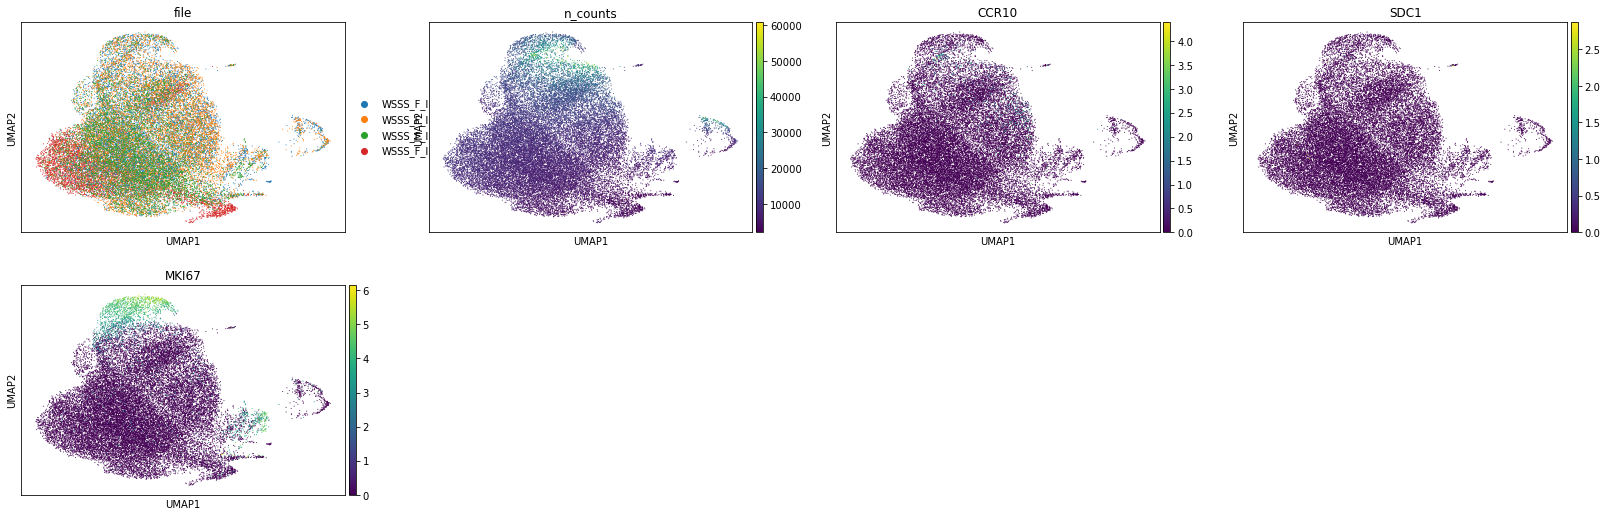

In [31]:
sc.pl.umap(sortedB_adata, color=['file', 'n_counts', "CCR10", "SDC1", "MKI67"])

### scVI embedding

In [12]:
import os,sys
import gc
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd

from typing import Union, Optional, Sequence, Any, Mapping, List, Tuple
from anndata import AnnData

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

import scvi
import torch
device = torch.device("cuda")

def _train_model(adata_ref, hvgs, n_hvgs=5000, batch_col=None):
    if batch_col is None:
        adata_ref.obs['batch'] = '1'
    else:
        adata_ref.obs['batch'] = adata_ref.obs[batch_col].copy()
    ## Select genes
    adata_ref = adata_ref[:,hvgs].copy()

    scvi.model.SCVI.setup_anndata(adata_ref, batch_key="batch", layer='counts')

    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )

    vae_ref = scvi.model.SCVI(
        adata_ref,
        **arches_params
    )

    vae_ref.train()
    adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
    return(vae_ref)

Global seed set to 0


In [47]:
sortedB_adata_raw = sortedB_adata.copy()

In [14]:
## Feature selection
n_hvgs = 7500
sortedB_adata.layers['counts'] = sortedB_adata.X.copy()

if 'log1p' not in sortedB_adata.uns.keys():
    sc.pp.normalize_per_cell(sortedB_adata)
    sc.pp.log1p(sortedB_adata)

sc.pp.highly_variable_genes(
    sortedB_adata,
    n_top_genes=n_hvgs,
    subset=True
)

hvgs = sortedB_adata.var_names.values

In [20]:
vae_ref = _train_model(sortedB_adata, hvgs, batch_col=None)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 29509 cells, 7500 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 271/271: 100%|██████████| 271/271 [09:17<00:00,  2.06s/it, loss=1.66e+03, v_num=1]


In [21]:
sortedB_adata.obsm["X_scVI"] = vae_ref.get_latent_representation()

In [50]:
sortedB_adata_raw.obsm["X_scVI"] = vae_ref.get_latent_representation()

In [51]:
sc.pp.neighbors(sortedB_adata_raw, n_neighbors=30, use_rep='X_scVI')

In [52]:
sc.tl.umap(sortedB_adata_raw)

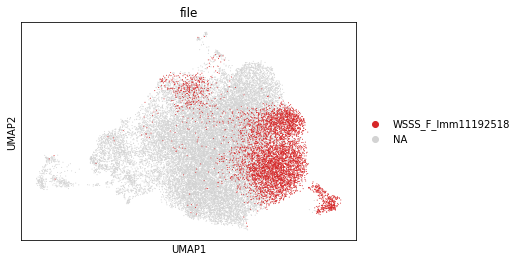

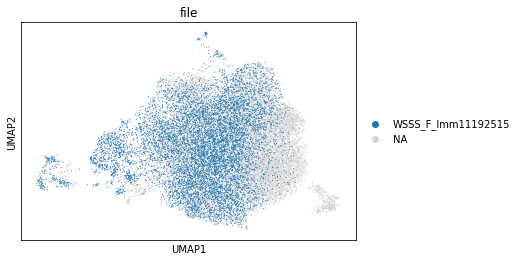

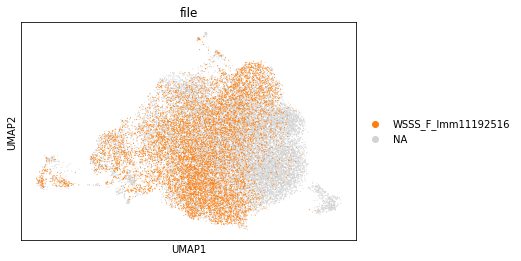

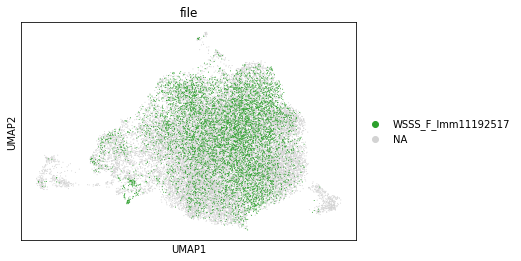

In [53]:
for g in sortedB_adata.obs['file'].unique():
    sc.pl.umap(sortedB_adata_raw, color=['file'], groups=g)


In [54]:
sortedB_adata_raw.var_names = sortedB_adata_raw.var['gene_name'].values.copy()

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


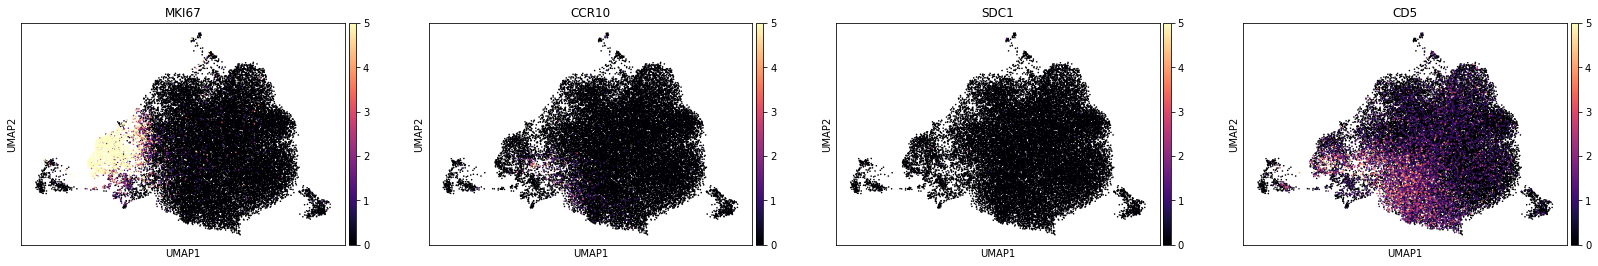

In [58]:
sc.pl.umap(sortedB_adata_raw, color=['MKI67',"CCR10", "SDC1", "CD5"], size=10, cmap='magma', vmax=5)

In [56]:
sortedB_adata_raw.write_h5ad('/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/sortedBcells_query.scVI.h5ad')